In [22]:
from IPython.display import HTML, display
import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import *
from nltk.corpus import names 

import unicodedata
import collections

import string

caring_path = "/Users/Sofia/Desktop/LING_506/project/data/data_version_01/cancer_research_living_with_cancer_05.csv"

caring_data = pd.read_csv(caring_path, delimiter="\t")
column_names = ['Thread_name', 'Thread_address', 'Username', "Post_id",
                                  "Date", "Post_text", "Reply_to_id"]


caring_data.head()

,Thread_name,Thread_address,Username,Post_id,Date,Post_text,Reply_to_id
0,Late December i was told i have prostate cancer,https://www.cancerresearchuk.org/about-cancer/...,psychicbob,post-1515791,8 Feb 2021 16:30,told bad enough scan late january since heard ...,NaN
1,SNLB result - moved to Stage III A melanoma,https://www.cancerresearchuk.org/about-cancer/...,nigel55,post-1518121,10 Feb 2021 14:26,hi everyone met mdt results yesterday moved st...,NaN
2,SVT after chemo,https://www.cancerresearchuk.org/about-cancer/...,joannemcfc,post-1518086,10 Feb 2021 14:18,hi 58 year old woman chemo radiation treatment...,NaN
3,Partial glossectomy,https://www.cancerresearchuk.org/about-cancer/...,nicki-d,post-940316,30 Jun 2019 05:06,diagnosed tongue cancer end may partial neck d...,NaN
4,Partial glossectomy,https://www.cancerresearchuk.org/about-cancer/...,chriss,post-941016,30 Jun 2019 18:40,hi sorry answer post maybe cancer many answeri...,post-940316


In [5]:
# REMOVE META-DATA COLUMNS

caring_data = caring_data.drop(['Thread_address', 'Username', "Post_id", "Date", "Reply_to_id"], axis=1).sample(100) # SAMPLE OF 100 ROWS 

# Print out the first rows of caring_data
caring_data.head()

,Thread_name,Post_text
25418,poem read at grans funeral,"['hi', 'kim', 'truly', 'sorry', 'hear', 'loss'..."
10157,"""Prophylactic mastectomy"" & ""boob job""","['bit', 'sad', 'hear', 'rather', 'young', 'lad..."
5180,Tablets for 5-10 years after Radiotherapy,"['thanks', 'replying', 'jackie', 'sorry', 'hea..."
8042,Want to stop Chemo,"['thanks', 'much']"
12006,"Good news, yet again","['thanks', 'river', 'brian']"


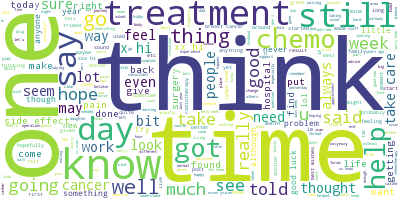

In [24]:
from wordcloud import WordCloud


# Join all posts together

long_strings = caring_data.Post_text.tolist()
long_string = " ".join(long_strings)

#print(long_string)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()



In [31]:
# Gensim
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



In [32]:
# Convert to list

data = caring_data.Post_text.values.tolist()
pprint(data[:1])

['told bad enough scan late january since heard phoned gp said told prostate '
 'cancer told said dont cancer test came back negative told phone hospital ask '
 'results scan said appointment email consultant asked results scan said '
 'consultant give asked took long nothing said busy']


In [33]:
# Tokenize

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['told', 'bad', 'enough', 'scan', 'late', 'january', 'since', 'heard', 'phoned', 'gp', 'said', 'told', 'prostate', 'cancer', 'told', 'said', 'dont', 'cancer', 'test', 'came', 'back', 'negative', 'told', 'phone', 'hospital', 'ask', 'results', 'scan', 'said', 'appointment', 'email', 'consultant', 'asked', 'results', 'scan', 'said', 'consultant', 'give', 'asked', 'took', 'long', 'nothing', 'said', 'busy']]


In [58]:
# Create dictionary and corpus for topic modeling

# Create Dictionary
id2word = corpora.Dictionary(data_words) # TEST OF PORTION OF TEXTS

# Create Corpus
texts = data_words # TEST OF PORTION OF TEXTS

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 4), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 5), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 2), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)]]


In [59]:
id2word[0]

'told'

In [39]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [54]:
# Build LDA model

# num_topics -- try 10, 15, 20

num_topics = 10

# chunksize -- return to 100

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = num_topics,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',
                                           per_word_topics = True)



In [55]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.048*"hi" + 0.045*"know" + 0.040*"good" + 0.034*"hope" + 0.030*"well" + '
  '0.025*"take" + 0.023*"help" + 0.021*"us" + 0.019*"keep" + 0.018*"best"'),
 (1,
  '0.025*"last" + 0.022*"treatment" + 0.020*"year" + 0.019*"week" + '
  '0.017*"weeks" + 0.017*"went" + 0.017*"said" + 0.017*"next" + 0.016*"anyone" '
  '+ 0.015*"hair"'),
 (2,
  '0.032*"day" + 0.022*"bit" + 0.021*"still" + 0.020*"family" + 0.019*"got" + '
  '0.019*"better" + 0.018*"today" + 0.017*"never" + 0.016*"thanks" + '
  '0.015*"done"'),
 (3,
  '0.125*"cancer" + 0.030*"told" + 0.029*"years" + 0.021*"breast" + '
  '0.017*"diagnosed" + 0.013*"prostate" + 0.012*"scan" + 0.011*"nothing" + '
  '0.011*"came" + 0.010*"doctor"'),
 (4,
  '0.054*"jules" + 0.038*"wig" + 0.029*"managed" + 0.028*"short" + '
  '0.027*"visit" + 0.025*"unfortunately" + 0.023*"cold" + 0.023*"heart" + '
  '0.021*"wear" + 0.014*"appreciate"'),
 (5,
  '0.068*"hospital" + 0.046*"home" + 0.044*"lisa" + 0.037*"surgery" + '
  '0.027*"peg" + 0.027*"op" + 0.0

In [56]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = data_words, dictionary = id2word, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.29051722437

Coherence Score:  0.376144446045


In [60]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

ValueError: Length of values does not match length of index

In [66]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

mallet_path = '/Users/Sofia/Desktop/LING_506/project/code/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 10, id2word = id2word)


In [67]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('feel', 0.054494695700725848),
   ('time', 0.044645449469570074),
   ('back', 0.033545505304299277),
   ('day', 0.030597431602456728),
   ('feeling', 0.029313232830820771),
   ('work', 0.027984366275823562),
   ('im', 0.027213847012841987),
   ('days', 0.023026242322724735),
   ('things', 0.02225572305974316),
   ('dont', 0.019854829704075934)]),
 (1,
  [('people', 0.036690698001029913),
   ('post', 0.02828753335518),
   ('read', 0.026461776134076121),
   ('support', 0.024062543888394738),
   ('find', 0.023676326014699687),
   ('kind', 0.019708815130377793),
   ('site', 0.016642479284677682),
   ('give', 0.016466925705725388),
   ('advice', 0.015331679228500539),
   ('forum', 0.014769907775853191)]),
 (2,
  [('cancer', 0.1342192913078834),
   ('treatment', 0.039522785754865154),
   ('years', 0.033295830502055229),
   ('diagnosed', 0.015584097314277439),
   ('diagnosis', 0.011585033028483587),
   ('treatments', 0.0095687917033340387),
   ('stage', 0.0093682815163025918),
   ('l

In [69]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = data_words,
                                           dictionary = id2word, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.468551381683
